# Dominant color determination with a neural network

This is an experiment to see whether a NN can be trained
to determine the dominant color.  Other experiments have shown
that k-means (subjectively) gives best results.  We'll use that
as the ground truth.

## Training data

The (CIFAR10)[https://www.cs.toronto.edu/~kriz/cifar.html] dataset is pragmatic.  It is readily
available under an open license.  Images are smaller than what was used for previous tests but
this has interesting implications for performance optimization.  Let's see where this leads.

The images are normalized to [0,1].  We'll have to account for this when manipulating RGB values.
Extant labels are not useful here.  We'll have to generate labels.

In [64]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.cluster import KMeans
import numpy as np

def algo_sklearn(data: np.array):
    kmeans = KMeans(n_clusters=4, init='k-means++').fit(data.reshape(-1,3))
    centroids = kmeans.cluster_centers_
    return tuple(centroids[0])

def make_labels(loader):
    labels = []
    for i, data in enumerate(loader, 0):
        images, _ = data
        for image in images:
            labels += [algo_sklearn(image.permute(1, 2, 0))]
        if i % 2000 == 1999:
            print(f"{i}");
            
    return labels

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
train_labels = make_labels(trainloader)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
test_labels = make_labels(testloader)



# Let's put all images onto the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Initializing device data")
device_images = []
device_targets = []
index = 0
for _, data in enumerate(trainloader, 0):
    images, _ = data
    for image in images:
        device_images += [ image.to(device) ]
        device_targets += [ torch.tensor(train_labels[index], dtype=torch.float32).to(device) ]
        index += 1



Files already downloaded and verified
1999
3999
5999
Files already downloaded and verified
Initializing device data


### Let's inspect the data

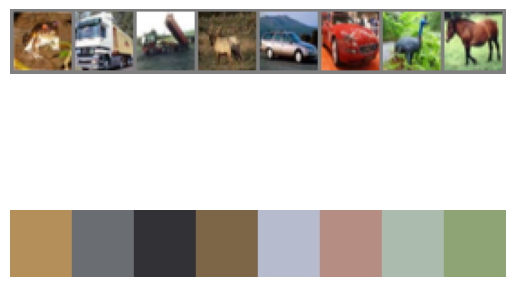

(np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408)) (np.float64(0.1148594773438082), np.float64(0.2866840317067372), np.float64(-0.08575476771856408))


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, _ = next(dataiter)

# show images
# imshow(torchvision.utils.make_grid(images))

# Create figure with subplots - one row for images, one for color swatches
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[4, 1])

# Show images in top subplot
img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
ax1.imshow(np.transpose(npimg, (1, 2, 0)))
ax1.axis('off')

# Create color swatches in bottom subplot
num_images = images.shape[0]
for i in range(num_images):
    # Create rectangle for each color
    rect = plt.Rectangle((i/num_images, 0), 1/num_images, 1, 
                        color=tuple(np.array(train_labels[i]) / 2 + 0.5))
    ax2.add_patch(rect)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

plt.show()
# print labels
print(' '.join(f'{train_labels[i]}' for j in range(batch_size)))

# Set up a Neural Network

The k-means algorithm that was used to determine the ground truth does not consider spacial data, just pixel values.
Intuitively there does not seem to be any reason to use a CNN.  However it seems plausible that like colors are clustered.  This implies that a CNN might help.

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class ColorNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: [3, 32, 32] (single image, no batch dimension)
        
        # Add convolutional layer to detect color patterns
        self.conv1 = nn.Conv2d(3, 3, kernel_size=5, padding=2)
        
        # First reduce spatial dimensions while keeping color information
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        
        # Flatten spatial dimensions
        self.flatten = nn.Flatten(start_dim=0)
        
        # Reduce to RGB through fully connected layers
        self.fc1 = nn.Linear(3 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 3)  # Final output is RGB values
        
        # Activation functions
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # Input: [3, 32, 32]
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Output: [3] (RGB values)
        return x


## Train

In [81]:
net = ColorNet()
net.to(device)

criterion = nn.MSELoss(reduction="sum")
optimizer = torch.optim.Adam(net.parameters(), lr=0.0005)

EPOCHS=50

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"Epoch {epoch + 1}")

    running_loss = 0.0
    index = 0
    for image, target in zip(device_images, device_targets):

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(image)
        
        # Convert tuple label to tensor
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        index += 1
        
        if index % 10000 == 9999:
            print(f'[{epoch + 1}, {index + 1:5d}] loss: {running_loss / 10000:.3f}')
            running_loss = 0.0

print('Finished Training')
torch.cuda.empty_cache()

Epoch 1
[1, 10000] loss: 0.672
[1, 20000] loss: 0.642
[1, 30000] loss: 0.649
[1, 40000] loss: 0.641
[1, 50000] loss: 0.636
Epoch 2
[2, 10000] loss: 0.656
[2, 20000] loss: 0.635
[2, 30000] loss: 0.644
[2, 40000] loss: 0.636
[2, 50000] loss: 0.632
Epoch 3
[3, 10000] loss: 0.653
[3, 20000] loss: 0.632
[3, 30000] loss: 0.641
[3, 40000] loss: 0.634
[3, 50000] loss: 0.629
Epoch 4
[4, 10000] loss: 0.651
[4, 20000] loss: 0.630
[4, 30000] loss: 0.639
[4, 40000] loss: 0.631
[4, 50000] loss: 0.628
Epoch 5
[5, 10000] loss: 0.648
[5, 20000] loss: 0.627
[5, 30000] loss: 0.638
[5, 40000] loss: 0.629
[5, 50000] loss: 0.625
Epoch 6
[6, 10000] loss: 0.645
[6, 20000] loss: 0.625
[6, 30000] loss: 0.635
[6, 40000] loss: 0.628
[6, 50000] loss: 0.621
Epoch 7
[7, 10000] loss: 0.641
[7, 20000] loss: 0.621
[7, 30000] loss: 0.631
[7, 40000] loss: 0.623
[7, 50000] loss: 0.618
Epoch 8
[8, 10000] loss: 0.637
[8, 20000] loss: 0.619
[8, 30000] loss: 0.629
[8, 40000] loss: 0.621
[8, 50000] loss: 0.613
Epoch 9
[9, 1000

In [61]:
PATH = './dc_net.pth'
torch.save(net.state_dict(), PATH)

In [50]:
torch.cuda.empty_cache()

## Apply the network to the test data

In [83]:

test_actuals = []
for i, data in enumerate(testloader, 0):
    images, _ = data
    for image in images:
        image = image.to(device)
        test_actuals += [ net(image).cpu().detach().numpy() ]
        
    

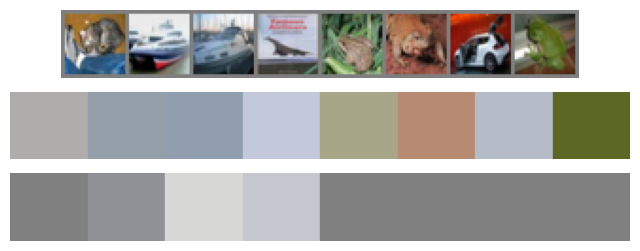

[2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00] [2.0784651e-35 0.0000000e+00 0.0000000e+00]


In [84]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(testloader)
images, _ = next(dataiter)

# show images
# imshow(torchvision.utils.make_grid(images))

# Create figure with subplots - one row for images, one for color swatches
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, height_ratios=[1, 1, 1], figsize=(8, 3))

# Show images in top subplot
img = torchvision.utils.make_grid(images)
img = img / 2 + 0.5     # unnormalize
npimg = img.numpy()
ax1.imshow(np.transpose(npimg, (1, 2, 0)))
ax1.axis('off')

# Create color swatches in bottom subplot
num_images = images.shape[0]
for i in range(num_images):
    # Create rectangle for each color
    rect = plt.Rectangle((i/num_images, 0), 1/num_images, 1, 
                        color=tuple(np.array(test_labels[i]) / 2 + 0.5))
    ax2.add_patch(rect)
    rect = plt.Rectangle((i/num_images, 0), 1/num_images, 1, 
                        color=tuple(np.array(test_actuals[i]) / 2 + 0.5))
    ax3.add_patch(rect)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')
ax3.set_xlim(0, 1)
ax3.set_ylim(0, 1)
ax3.axis('off')

plt.show()
# print labels
print(' '.join(f'{test_actuals[i]}' for j in range(batch_size)))